In [1]:
#!pip install rdkit-pypi --upgrade --force-reinstall
!pip install numpy --upgrade --force-reinstall
!pip install rdkit-pypi
from google.colab import files
uploaded = files.upload()
input_csv = list(uploaded.keys())[0]



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 61.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.1 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.1 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 25.8 MB/s eta 0:00:00


KeyboardInterrupt: 

In [1]:
import os
import pandas as pd
import multiprocessing as mp
import zipfile
import re
from tqdm.notebook import tqdm
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Descriptors import MolWt as mw

def getlargestfrag(smi):
    if not isinstance(smi, str) or smi is None:
        return None
    largest = "[*]"
    for i in smi.split('.'):
        try:
            if Chem.MolFromSmiles(i).GetNumHeavyAtoms() > Chem.MolFromSmiles(largest).GetNumHeavyAtoms():
                largest = i
        except:
            return None
    return Chem.MolToSmiles(Chem.MolFromSmiles(largest)) if largest != "[*]" else None

def NeutraliseCharges(mol):
    reactions = [
        ('[n+;H]', 'n'), ('[N+;!H0]', 'N'), ('[$([O-]);!$([O-][#7])]', 'O'),
        ('[S-;X1]', 'S'), ('[$([N-;X2]S(=O)=O)]', 'N'), ('[$([N-;X2][C,N]=C)]', 'N'),
        ('[n-]', '[nH]'), ('[$([S-]=O)]', 'S'), ('[$([N-]C=O)]', 'N')
    ]
    rxns = [(Chem.MolFromSmarts(x), Chem.MolFromSmiles(y, False)) for x, y in reactions]
    for reactant, product in rxns:
        while mol.HasSubstructMatch(reactant):
            mol = AllChem.ReplaceSubstructs(mol, reactant, product)[0]
    return mol

def Wash(smi):
    smi = getlargestfrag(smi)
    if smi is None:
        return None
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    if '+' in smi or '-' in smi:
        mol = NeutraliseCharges(mol)
    AllChem.RemoveStereochemistry(mol)
    return Chem.MolToSmiles(mol)

def wash_dataset(df, smiles_col, ncpu=4):
    df = df[[smiles_col]].dropna().reset_index(drop=True).rename(columns={smiles_col: 'Molecule'})
    with mp.Pool(ncpu) as pool:
        df['washed'] = list(tqdm(pool.imap(Wash, df['Molecule']), total=len(df), desc='Lavando SMILES'))
    df = df.dropna(subset=['washed']).drop_duplicates(subset=['washed']).reset_index(drop=True)
    df['WID'] = ['W' + str(i) for i in range(len(df))]
    return df

def get_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        core = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(core)
    return None

def getFrags(analog, core):
    wid = analog.index[0]
    analog = Chem.MolFromSmiles(analog.values[0])
    core = Chem.MolFromSmiles(core)
    frags = Chem.MolToSmiles(Chem.ReplaceCore(analog, core, analog.GetSubstructMatch(core), labelByIndex=True), isomericSmiles=True).split(".")
    subs = {"WID": wid}
    for j in frags:
        try:
            subs[int(re.search(r"\[(.*?)\*\]", j).group(1))] = re.sub(r"\[(.*?)\*\]", "[*]", j)
        except:
            subs[0] = re.sub(r"\*", "[*]", j)
    return subs

def Rtab(analogs, core):
    frags = [getFrags(analogs[[k]], core) for k in range(len(analogs))]
    res = pd.DataFrame(frags).set_index("WID").fillna("[H]")
    res[res == ""] = "[H]"
    keep = (res.apply(lambda x: (x == "[H]").mean()) != 1)
    return res.loc[:, keep[keep].index]

def mol_with_atom_index(mol):
    for idx in range(mol.GetNumAtoms()):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(idx))
    return mol

def Rcore(core, analogs, filename=None):
    Rtable = Rtab(analogs, core)
    mol = mol_with_atom_index(Chem.MolFromSmiles(core))
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 200)
    atom_indices = [i for i in Rtable.columns if isinstance(i, int) and i < mol.GetNumAtoms()]
    drawer.DrawMolecule(mol, highlightAtoms=atom_indices)
    drawer.FinishDrawing()
    fig_svg = drawer.GetDrawingText().replace('svg:', '')
    if filename:
        with open(f"{filename}.svg", "w") as f:
            f.write(fig_svg)
        Rtable.to_csv(f"{filename}.csv")
    return fig_svg, Rtable

def run_pipeline(input_csv, smiles_column='CanonicalSMILES', top_n_cores=10):
    df = pd.read_csv(input_csv)
    washed_df = wash_dataset(df, smiles_col=smiles_column)
    washed_df['scaffold'] = washed_df['washed'].apply(get_scaffold)
    washed_df = washed_df.dropna(subset=['scaffold'])
    washed_df['CRID'] = washed_df['scaffold'].astype('category').cat.codes

    top_scaffolds = washed_df['scaffold'].value_counts().head(top_n_cores).index

    os.makedirs("output", exist_ok=True)
    zipf = zipfile.ZipFile("constellations.zip", 'w', zipfile.ZIP_DEFLATED)

    for i, core in enumerate(tqdm(top_scaffolds, desc="Processando scaffolds")):
        grupo = washed_df[washed_df['scaffold'] == core]
        analogs = grupo.set_index('WID')['washed']
        fig_svg, rtable = Rcore(core, analogs, filename=f"output/core_{i+1}")
        zipf.write(f"output/core_{i+1}.svg")
        zipf.write(f"output/core_{i+1}.csv")

    washed_df.to_csv("output/washed_full_dataset.csv", index=False)
    zipf.write("output/washed_full_dataset.csv")
    zipf.close()

    print("✅ Arquivo constellations.zip criado com sucesso.")
    return "constellations.zip"



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

In [ ]:
run_pipeline(input_csv, smiles_column='CanonicalSMILES', top_n_cores=10)


Lavando SMILES:   0%|          | 0/30696 [00:00<?, ?it/s]

Processando scaffolds:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-5-1703ba9214e7>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frags = [getFrags(analogs[[k]], core) for k in range(len(analogs))]
<ipython-input-5-1703ba9214e7>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frags = [getFrags(analogs[[k]], core) for k in range(len(analogs))]
<ipython-input-5-1703ba9214e7>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frags = [getFrags(analogs[[k]], core) for k in range(len(

✅ Arquivo constellations.zip criado com sucesso.


<ipython-input-5-1703ba9214e7>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frags = [getFrags(analogs[[k]], core) for k in range(len(analogs))]
<ipython-input-5-1703ba9214e7>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frags = [getFrags(analogs[[k]], core) for k in range(len(analogs))]
<ipython-input-5-1703ba9214e7>:78: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frags = [getFrags(analogs[[k]], core) for k in range(len(

'constellations.zip'

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
import matplotlib.pyplot as plt
import zipfile
import os
!pip install -U kaleido

# Criar diretórios de saída
os.makedirs("output/series_csv", exist_ok=True)
os.makedirs("output/scaffold_svgs", exist_ok=True)

# Carregar dados do pipeline
df = pd.read_csv("output/washed_full_dataset.csv")

# Eliminar scaffolds inválidos
df = df.dropna(subset=['scaffold', 'CRID'])

# Mapear scaffold por CRID
scaffold_lookup = df.groupby('CRID')['scaffold'].first().dropna().to_dict()

# Função segura de fingerprint
def fingerprint(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            return GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    except:
        return None

# Gerar fingerprints válidos
fps = {crid: fingerprint(smi) for crid, smi in scaffold_lookup.items()}
fps = {k: v for k, v in fps.items() if v is not None}

# Redefinir CRIDs válidos
crid_list = list(fps.keys())
series_sizes = df[df['CRID'].isin(crid_list)]['CRID'].value_counts().sort_index()

# Calcular similaridades (Tanimoto)
edges = []
threshold = 0.8
for i in range(len(crid_list)):
    for j in range(i+1, len(crid_list)):
        sim = DataStructs.TanimotoSimilarity(fps[crid_list[i]], fps[crid_list[j]])
        if sim >= threshold:
            edges.append((crid_list[i], crid_list[j], sim))

# Construir grafo
G = nx.Graph()
for crid in crid_list:
    G.add_node(crid, size=series_sizes.get(crid, 1))
for i, j, sim in edges:
    G.add_edge(i, j, weight=sim)

# Layout
pos = nx.spring_layout(G, seed=42, k=0.5)

# Arestas
edge_x, edge_y = [], []
for e in G.edges():
    x0, y0 = pos[e[0]]
    x1, y1 = pos[e[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Nós
node_x, node_y, sizes, texts = [], [], [], []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    size = G.nodes[node]['size']
    sizes.append(size)
    texts.append(f"CRID {node}<br>Compostos: {size}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    textposition='top center',
    marker=dict(
        showscale=True,
        colorscale='Viridis',
        color=sizes,
        size=[5 + np.log2(s + 1) * 10 for s in sizes],
        colorbar=dict(
            thickness=15,
            title='Tamanho da série',
            xanchor='left'
        ),
        line_width=1
    ),
    text=[f"CRID {crid}" for crid in G.nodes()],
    hovertext=texts
)

# Figura Plotly com título corrigido
fig = go.Figure(data=[edge_trace, node_trace],
    layout=go.Layout(
        title=dict(
            text='Gráfico de Constelação de Séries de Análogos',
            font=dict(size=20)
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        annotations=[dict(
            text="Arestas conectam scaffolds com Tanimoto ≥ 0.8",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.005, y=-0.002)],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
)


# Mostrar gráfico interativo antes de salvar
fig.show()

# Salvar PNG e SVG
fig.write_image("constellation_plot.png", scale=6, width=1200, height=800)
fig.write_image("constellation_plot.svg", width=1200, height=800)

# Salvar PNG e SVG
fig.write_image("constellation_plot.png", scale=6, width=1200, height=800)
fig.write_image("constellation_plot.svg", width=1200, height=800)

# Salvar .csv e .svg para cada série
for crid in crid_list:
    subset = df[df['CRID'] == crid]
    subset.to_csv(f"output/series_csv/CRID_{crid}.csv", index=False)

    scaffold_smi = scaffold_lookup[crid]
    mol = Chem.MolFromSmiles(scaffold_smi)
    if mol:
        Draw.MolToFile(mol, f"output/scaffold_svgs/CRID_{crid}.svg", size=(300, 300))

# Empacotar resultados
with zipfile.ZipFile("constellations_with_series.zip", 'w', zipfile.ZIP_DEFLATED) as zf:
    zf.write("constellation_plot.png")
    zf.write("constellation_plot.svg")
    zf.write("output/washed_full_dataset.csv")

    for root, _, files in os.walk("output/series_csv"):
        for f in files:
            zf.write(os.path.join(root, f), arcname=f"series_csv/{f}")

    for root, _, files in os.walk("output/scaffold_svgs"):
        for f in files:
            zf.write(os.path.join(root, f), arcname=f"scaffold_svgs/{f}")

# Baixar zip final
from google.colab import files
files.download("constellations_with_series.zip")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.6 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# histogram

<ipython-input-8-0620a2f617e9>:23: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



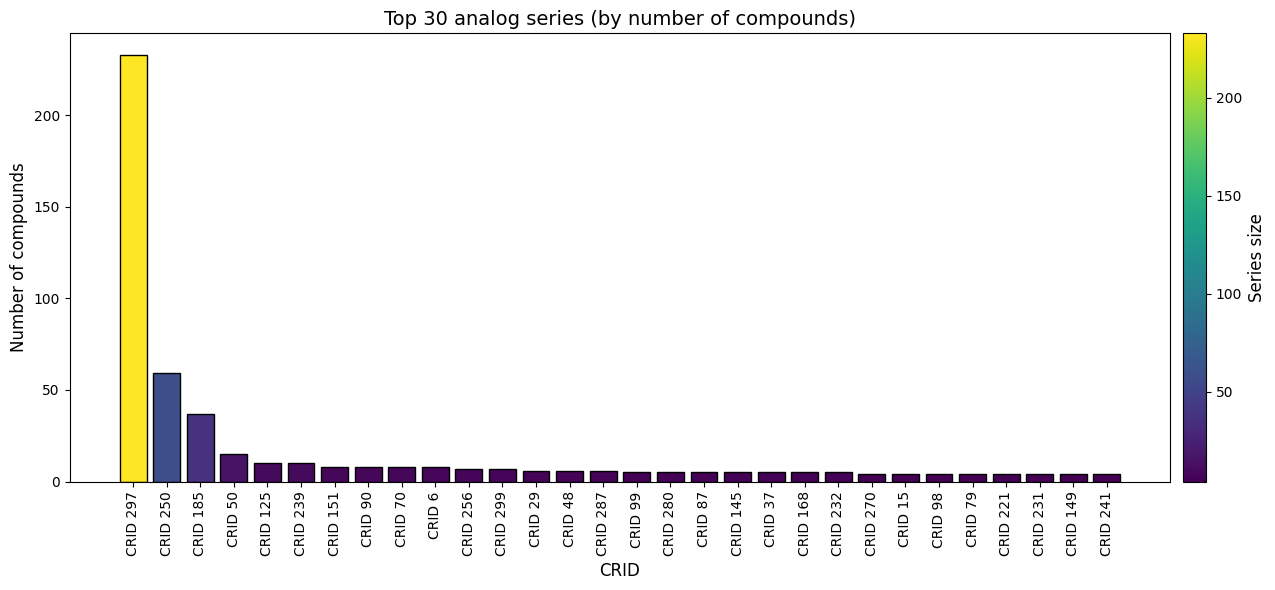

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Top 30 maiores séries
top_30_series = series_sizes.sort_values(ascending=False).head(30)

# Normalizar manualmente o espectro de cor
norm = mcolors.Normalize(vmin=top_30_series.min(), vmax=top_30_series.max())
cmap = plt.colormaps['viridis']  # ✅ forma atual recomendada

# Aplicar cores à mão
colors = [cmap(norm(v)) for v in top_30_series.values]

# Rótulos no estilo "CRID 123"
labels = [f"CRID {crid}" for crid in top_30_series.index]

# Criar figura e eixo
fig, ax = plt.subplots(figsize=(14, 6))

# Plot
bars = ax.bar(labels, top_30_series.values, color=colors, edgecolor='black')
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Top 30 analog series (by number of compounds)', fontsize=14)
ax.set_xlabel('CRID', fontsize=12)
ax.set_ylabel('Number of compounds', fontsize=12)

# Colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # necessário para criar a colorbar
cbar = fig.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label('Series size', fontsize=12)

# Ajustar layout e salvar
plt.tight_layout()
plt.savefig("top_30_series_histograma.png", dpi=600)
plt.show()
files.download("top_30_series_histograma.png")


# variação horizontal

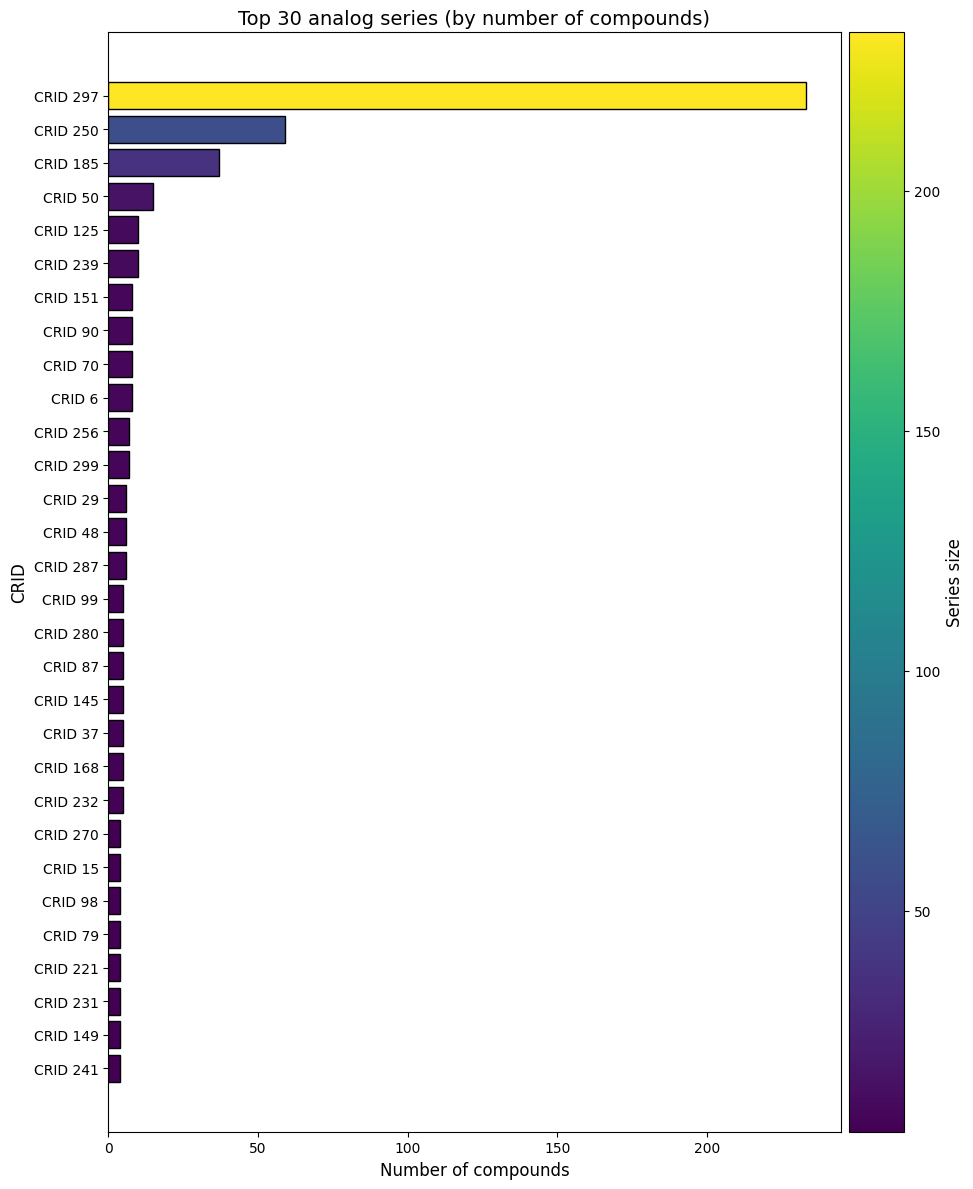

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from google.colab import files

# Top 30 maiores séries
top_30_series = series_sizes.sort_values(ascending=False).head(30)

# Normalizar cores
norm = mcolors.Normalize(vmin=top_30_series.min(), vmax=top_30_series.max())
cmap = plt.colormaps['viridis']
colors = [cmap(norm(v)) for v in top_30_series.values]

# Rótulos no estilo "CRID 123"
labels = [f"CRID {crid}" for crid in top_30_series.index]

# Criar figura e eixo
fig, ax = plt.subplots(figsize=(10, 12))  # Ajustar altura para caber os rótulos

# Plot horizontal
bars = ax.barh(labels, top_30_series.values, color=colors, edgecolor='black')
ax.invert_yaxis()  # Coloca a maior série no topo
ax.set_title('Top 30 analog series (by number of compounds)', fontsize=14)
ax.set_xlabel('Number of compounds', fontsize=12)
ax.set_ylabel('CRID', fontsize=12)

# Colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label('Series size', fontsize=12)

# Layout e salvar
plt.tight_layout()
plt.savefig("top_30_series_horizontal.png", dpi=600)
plt.show()

files.download("top_30_series_horizontal.png")


### variações de diferentes valores de tanimotto: fazer 0.5 (quantos agrupam?), 0.7, 0.8 em uma tabela. pesquisar como saber quantos scaffolds se comunicam com arestas em cada configuração.

In [ ]:
# Versão compacta: uma linha por grupo, CRIDs separados por vírgula
component_df['CRIDs'] = component_df['CRIDs'].apply(lambda x: ', '.join(map(str, x)))
component_df.to_csv("grupos_conectados_compacto.csv", index=False)

# Baixar no Colab
files.download("grupos_conectados_compacto.csv")


NameError: name 'component_df' is not defined

In [ ]:
# ... (mantém todo o seu código até esta parte inalterado)

# Atribuir cor por grupo
color_map = []
for node in G.nodes():
    if node in grupo_roxo:
        color_map.append('purple')
    elif node in grupo_verde:
        color_map.append('green')
    else:
        color_map.append('lightgray')

# Substitui o node_trace para usar as cores corrigidas (color_map)
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    textposition='top center',
    marker=dict(
        showscale=False,  # Desativa escala automática
        color=color_map,
        size=[5 + np.log2(s + 1) * 10 for s in sizes],
        line_width=1
    ),
    text=[f"CRID {crid}" for crid in G.nodes()],
    hovertext=texts
)

# Figura Plotly com título corrigido
fig = go.Figure(data=[edge_trace, node_trace],
    layout=go.Layout(
        title=dict(
            text='Gráfico de Constelação de Séries de Análogos (Grupos 42 e 77 em destaque)',
            font=dict(size=20)
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        annotations=[dict(
            text="Arestas conectam scaffolds com Tanimoto ≥ 0.8",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.005, y=-0.002)],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
)

# Mostrar gráfico interativo
fig.show()

# Salvar PNG e SVG
fig.write_image("constellation_plot.png", scale=6, width=1200, height=800)
fig.write_image("constellation_plot.svg", width=1200, height=800)

# Salvar .csv e .svg para cada série
for crid in crid_list:
    subset = df[df['CRID'] == crid]
    subset.to_csv(f"output/series_csv/CRID_{crid}.csv", index=False)

    scaffold_smi = scaffold_lookup[crid]
    mol = Chem.MolFromSmiles(scaffold_smi)
    if mol:
        Draw.MolToFile(mol, f"output/scaffold_svgs/CRID_{crid}.svg", size=(300, 300))

# Empacotar resultados
with zipfile.ZipFile("constellations_with_series.zip", 'w', zipfile.ZIP_DEFLATED) as zf:
    zf.write("constellation_plot.png")
    zf.write("constellation_plot.svg")
    zf.write("output/washed_full_dataset.csv")

    for root, _, files in os.walk("output/series_csv"):
        for f in files:
            zf.write(os.path.join(root, f), arcname=f"series_csv/{f}")

    for root, _, files in os.walk("output/scaffold_svgs"):
        for f in files:
            zf.write(os.path.join(root, f), arcname=f"scaffold_svgs/{f}")

# Baixar zip final
from google.colab import files
files.download("constellations_with_series.zip")


NameError: name 'grupo_roxo' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Função para salvar imagem focada em um grupo
def salvar_zoom_grupo(grupo_crids, nome_grupo, cor='blue'):
    # Subgrafo
    subgraph = G.subgraph(grupo_crids)
    sub_pos = {n: pos[n] for n in subgraph.nodes()}  # usar as mesmas posições do grafo principal

    # Tamanho do nó baseado no número de compostos
    sub_sizes = [G.nodes[n]['size'] for n in subgraph.nodes()]
    node_sizes = [100 + np.log2(s + 1) * 100 for s in sub_sizes]

    # Plot com matplotlib
    plt.figure(figsize=(6, 6))
    nx.draw(
        subgraph,
        pos=sub_pos,
        with_labels=True,
        node_color=cor,
        node_size=node_sizes,
        edge_color='gray',
        font_size=10,
        font_color='white'
    )
    plt.title(f"Zoom no {nome_grupo}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{nome_grupo}_zoom.png", dpi=600)
    plt.close()

# Salvar imagens dos grupos com ≥5 membros
salvar_zoom_grupo(grupo_roxo, "Grupo_42", cor='purple')
salvar_zoom_grupo(grupo_verde, "Grupo_77", cor='green')

# Baixar se desejar (opcional)
from google.colab import files
files.download("Grupo_42_zoom.png")
files.download("Grupo_77_zoom.png")


<ipython-input-22-78f7f292a7b3>:27: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(df.columns)


Index(['Molecule', 'washed', 'WID', 'scaffold', 'CRID'], dtype='object')


In [ ]:
# Definir os grupos
grupo_a = [90, 91, 92, 93, 94, 95, 96]
grupo_b = [46, 50, 51, 52, 53]

# Função para filtrar e montar tabela de similaridades internas
def tabela_similaridades_grupo(edges, grupo, nome_grupo):
    df_edges = pd.DataFrame(edges, columns=['CRID_1', 'CRID_2', 'Tanimoto'])

    # Manter apenas pares onde ambos os CRIDs estão no grupo
    df_grupo = df_edges[
        df_edges['CRID_1'].isin(grupo) & df_edges['CRID_2'].isin(grupo)
    ].copy()

    # Adicionar scaffolds
    df_grupo['Scaffold_1'] = df_grupo['CRID_1'].map(scaffold_lookup)
    df_grupo['Scaffold_2'] = df_grupo['CRID_2'].map(scaffold_lookup)

    # Salvar CSV
    filename = f"similaridade_{nome_grupo}.csv"
    df_grupo.to_csv(filename, index=False)
    return df_grupo, filename

# Executar para os dois grupos
df_a, arquivo_a = tabela_similaridades_grupo(edges, grupo_a, "Grupo_A_CRID90a96")
df_b, arquivo_b = tabela_similaridades_grupo(edges, grupo_b, "Grupo_B_CRID46e50a53")

# Baixar arquivos
from google.colab import files
files.download(arquivo_a)
files.download(arquivo_b)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import pandas as pd
import re

def gerar_svg_grupo_crids(df, scaffold_lookup, grupo_crids, nome_arquivo):
    # Criar pasta se não existir
    os.makedirs("output/grupos_comparados", exist_ok=True)

    # Filtrar os compostos do grupo
    subset = df[df['CRID'].isin(grupo_crids)].copy()
    subset = subset.dropna(subset=['washed', 'scaffold'])

    # Scaffold mais comum
    core = subset['scaffold'].value_counts().idxmax()

    # Serie: WID -> SMILES
    analogs = subset.set_index('WID')['washed']

    # Funções auxiliares
    def getFrags(analog, core):
        wid = analog.index[0]
        analog = Chem.MolFromSmiles(analog.values[0])
        core_mol = Chem.MolFromSmiles(core)
        frags = Chem.MolToSmiles(
            Chem.ReplaceCore(analog, core_mol, analog.GetSubstructMatch(core_mol), labelByIndex=True),
            isomericSmiles=True
        ).split(".")
        subs = {"WID": wid}
        for j in frags:
            try:
                subs[int(re.search(r"\[(.*?)\*\]", j).group(1))] = re.sub(r"\[(.*?)\*\]", "[*]", j)
            except:
                subs[0] = re.sub(r"\*", "[*]", j)
        return subs

    def Rtab(analogs, core):
        frags = [getFrags(analogs[[k]], core) for k in range(len(analogs))]
        res = pd.DataFrame(frags).set_index("WID").fillna("[H]")
        res[res == ""] = "[H]"
        keep = (res.apply(lambda x: (x == "[H]").mean()) != 1)
        return res.loc[:, keep[keep].index]

    def mol_with_atom_index(mol):
        for idx in range(mol.GetNumAtoms()):
            mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(idx))
        return mol

    # Gerar tabela de substituintes
    rtable = Rtab(analogs, core)

    # Gerar imagem com átomos destacados
    mol = mol_with_atom_index(Chem.MolFromSmiles(core))
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(400, 200)
    atom_indices = [i for i in rtable.columns if isinstance(i, int) and i < mol.GetNumAtoms()]
    drawer.DrawMolecule(mol, highlightAtoms=atom_indices)
    drawer.FinishDrawing()
    fig_svg = drawer.GetDrawingText().replace('svg:', '')

    # Salvar imagem e tabela
    svg_path = f"output/grupos_comparados/{nome_arquivo}.svg"
    csv_path = f"output/grupos_comparados/{nome_arquivo}.csv"
    with open(svg_path, "w") as f:
        f.write(fig_svg)
    rtable.to_csv(csv_path)

    print(f"✅ Arquivos salvos: {svg_path} e {csv_path}")



In [ ]:
# Exemplo de uso
grupo_a = [90, 91, 92, 93, 94, 95, 96]
grupo_b = [46, 50, 51, 52, 53]

gerar_svg_grupo_crids(df, scaffold_lookup, grupo_a, "grupo_A")
gerar_svg_grupo_crids(df, scaffold_lookup, grupo_b, "grupo_B")

import zipfile
import os
from google.colab import files

# Caminho de saída
output_dir = "output/grupos_comparados"
zip_filename = "grupos_comparados.zip"

# Verifica se a pasta existe
if os.path.exists(output_dir):
    # Cria o .zip
    with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files_list in os.walk(output_dir):
            for file in files_list:
                full_path = os.path.join(root, file)
                relative_path = os.path.relpath(full_path, start=output_dir)
                zipf.write(full_path, arcname=relative_path)

    # Baixa o zip
    files.download(zip_filename)
else:
    print(f"Pasta '{output_dir}' não encontrada.")




✅ Arquivos salvos: output/grupos_comparados/grupo_A.svg e output/grupos_comparados/grupo_A.csv
✅ Arquivos salvos: output/grupos_comparados/grupo_B.svg e output/grupos_comparados/grupo_B.csv


<ipython-input-36-6773c74317ca>:40: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-36-6773c74317ca>:40: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install numpy==1.26.4 pandas==2.2.2 scipy==1.13.0 scikit-learn==1.4.2 --force-reinstall
!pip install rdkit-pypi seaborn


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached scipy-1.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux20

In [ ]:
!pip install -q rdkit-pypi seaborn scikit-learn --force-reinstall


import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar planilha
df = pd.read_csv("output/washed_full_dataset.csv")

# Limpar dados e remover CRID 297
df = df.dropna(subset=["scaffold", "CRID"])
df = df[df["CRID"] != 297]

# Mapear scaffold por CRID
scaffold_lookup = df.groupby("CRID")["scaffold"].first().dropna().to_dict()

# Função de fingerprint
def fingerprint(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    except:
        return None

# Gerar fingerprints
fps = {crid: fingerprint(smi) for crid, smi in scaffold_lookup.items()}
fps = {k: v for k, v in fps.items() if v is not None}

# Converter fingerprints em matriz numpy
crid_list = list(fps.keys())
fp_array = []
for crid in crid_list:
    arr = np.zeros((2048,))
    DataStructs.ConvertToNumpyArray(fps[crid], arr)
    fp_array.append(arr)
fp_array = np.array(fp_array)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(fp_array)

# Criar dataframe para visualização
tsne_df = pd.DataFrame(tsne_result, columns=["TSNE1", "TSNE2"])
tsne_df["CRID"] = crid_list
tsne_df["Size"] = tsne_df["CRID"].map(df["CRID"].value_counts().to_dict())

# Plot com seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", size="Size", sizes=(20, 300), legend=False)
plt.title("t-SNE Projection of Analog Series Scaffolds")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
langchain-core 0.3.56 requires packaging<25,>=23.2, but you have packaging 25.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.


ValueError: All ufuncs must have type `numpy.ufunc`. Received (<ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>, <ufunc 'sph_legendre_p'>)

In [ ]:
# Ver distribuição das similaridades (excluindo a diagonal)
similarities = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
print("Resumo das similaridades Tanimoto entre scaffolds:")
print(pd.Series(similarities).describe())


NameError: name 'sim_matrix' is not defined